# ARIMA

This model can predict several prices in the future.

## Importing libraries

In [3]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings
from pandas import Series


# Files
from indicators import get_momentum, get_RSI, get_sma, plot_stock_prices_prediction
from util import fetchOnlineData, slice_df

# Plot
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn import tree, metrics, neighbors

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
import statsmodels
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf

# TA Library (https://github.com/bukosabino/ta)
from ta import *

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



/home/emi/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## Initial variables

In [6]:
symbol = "AABA"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Getting data from Yahoo

In [7]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


In [8]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [9]:
# Convert price column to float
#normed[symbol] = pd.to_numeric(normed[symbol], downcast='float', errors='coerce').fillna(0)

In [10]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-03-19 to 2019-03-15
Data columns (total 1 columns):
Adj Close    250 non-null float64
dtypes: float64(1)
memory usage: 3.9 KB


,Adj Close
Date,
2018-03-19,77.839996
2018-03-20,79.070000
2018-03-21,78.070000
2018-03-22,74.570000
2018-03-23,73.000000


## Getting indicator values

In [11]:
def get_indicators(normed, symbol):

    # Compute momentum
    sym_mom = get_momentum(normed[symbol], window=10)

    # ****Relative Strength Index (RSI)****
    # Compute RSI
    rsi_value = get_RSI(normed[symbol], 7)

    # ****Simple moving average (SMA)****
    # Compute SMA
    sma, q = get_sma(normed[symbol], window=10)
    return sym_mom, sma, q, rsi_value

#normed = scaling_data(normed, symbol)

normed['date'] = portf_value.index
normed.set_index('date', inplace=True)
normed.rename(columns={'Adj Close': symbol}, inplace=True)


In [12]:
# Get indicators
sym_mom, sma, q, rsi_value = get_indicators(normed, symbol)


# Create momentum column
normed['Momentum'] = sym_mom

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi_value

date
2018-04-03   -0.093911
2018-04-04   -0.120779
2018-04-05   -0.111310
2018-04-06   -0.094140
2018-04-09   -0.062466
2018-04-10   -0.066350
2018-04-11   -0.033959
2018-04-12   -0.028910
2018-04-13   -0.064155
2018-04-16   -0.023464
2018-04-17    0.007940
2018-04-18    0.040276
2018-04-19    0.038051
2018-04-20    0.051961
2018-04-23    0.021186
2018-04-24   -0.021475
2018-04-25   -0.032318
2018-04-26   -0.010490
2018-04-27    0.006350
2018-04-30    0.002288
2018-05-01   -0.016880
2018-05-02   -0.029176
2018-05-03   -0.022771
2018-05-04    0.023220
2018-05-07    0.077837
2018-05-08    0.097892
2018-05-09    0.112202
2018-05-10    0.087393
2018-05-11    0.085186
2018-05-14    0.095034
                ...   
2019-02-01    0.065133
2019-02-04    0.058323
2019-02-05    0.111728
2019-02-06    0.112454
2019-02-07    0.071094
2019-02-08    0.050598
2019-02-11    0.050291
2019-02-12    0.063127
2019-02-13    0.015437
2019-02-14    0.001606
2019-02-15   -0.009632
2019-02-19    0.010232
2019-0

In [13]:
normed.info()
# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2018-03-19 to 2019-03-15
Data columns (total 4 columns):
AABA        250 non-null float64
Momentum    240 non-null float64
SMA         241 non-null float64
RSI         250 non-null float64
dtypes: float64(4)
memory usage: 9.8 KB


,AABA,Momentum,SMA,RSI
date,,,,
2018-03-19,77.839996,0.000000,0.000000,37.057240
2018-03-20,79.070000,0.000000,0.000000,37.057240
2018-03-21,78.070000,0.000000,0.000000,37.057240
2018-03-22,74.570000,0.000000,0.000000,37.057240
2018-03-23,73.000000,0.000000,0.000000,37.057240
2018-03-26,75.809998,0.000000,0.000000,37.057240
2018-03-27,73.029999,0.000000,0.000000,37.057240
2018-03-28,72.639999,0.000000,0.000000,35.943197
2018-03-29,74.040001,0.000000,0.000000,43.106340


## Checking missing data

In [14]:
#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


## Correlation matrix

--------------- CORRELATIONS ---------------
              AABA  Momentum       SMA       RSI
AABA      1.000000  0.293553  0.212934  0.369687
Momentum  0.293553  1.000000  0.010606  0.861549
SMA       0.212934  0.010606  1.000000  0.174602
RSI       0.369687  0.861549  0.174602  1.000000


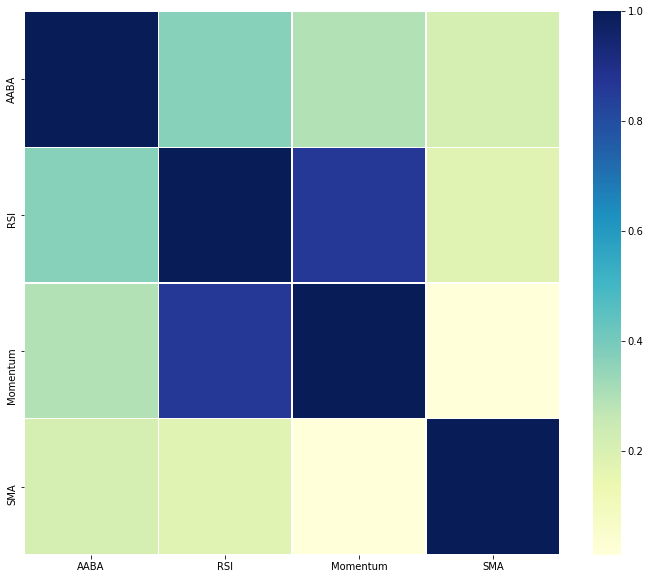

In [15]:
corr_df = normed.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
print(corr_df)

# Adj Close correlation matrix
corrmat = normed.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, symbol)[symbol].index
cm = np.corrcoef(normed[cols].values.T)
f, ax = plt.subplots(figsize =(12, 10)) 
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 
plt.show()

### Setting up the Target variable or the desired output.

In [68]:
# Define X and y
feature_cols = ['Momentum', 'RSI']
X = normed[feature_cols]
y = normed[symbol]

NameError: name 'normed' is not defined

### Split the data

In [17]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)

# ARIMA Model

## Stationarity

In [18]:
#Checking stationarity second way
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=12).std()
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

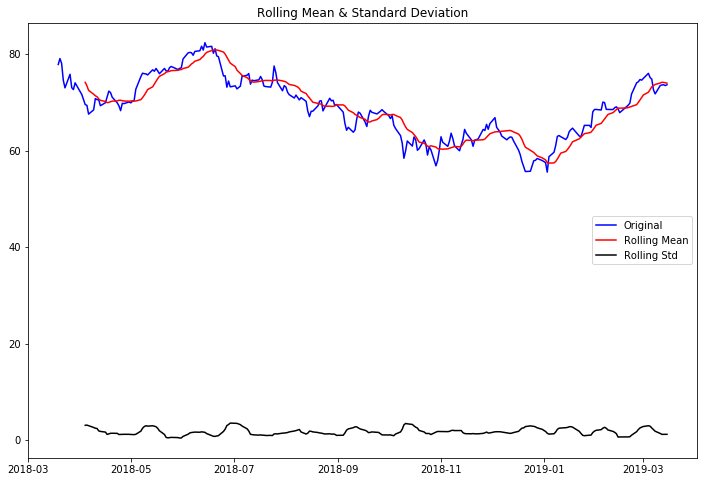

Results of Dickey-Fuller Test:
Test Statistic                  -1.573566
p-value                          0.496857
#Lags Used                       4.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [19]:
test_stationarity(normed[symbol])

As we can see:
Test Statistic is greater than Critical Value, so the **time series is stationary**

### Tuning the ARIMA model

In [20]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

### Evaluate parameters

### Optimal ARIMA model 

Find the optimal ARIMA model manually using Out-of-Time Cross validation.

In Out-of-Time cross-validation, you take few steps back in time and forecast into the future to as many steps you took back. Then you compare the forecast against the actuals.

To do out-of-time cross-validation, you need to create the training and testing dataset by splitting the time series into 2 contiguous parts in approximately 75:25 ratio or a reasonable proportion based on time frequency of series.

Why am I not sampling the training data randomly you ask?

That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [740]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=55.746
ARIMA(0, 0, 1) MSE=17.231
ARIMA(0, 1, 0) MSE=1.480
ARIMA(0, 1, 1) MSE=1.448
ARIMA(0, 1, 2) MSE=1.475
ARIMA(0, 2, 0) MSE=2.345
ARIMA(0, 2, 1) MSE=1.500
ARIMA(0, 2, 2) MSE=1.466
ARIMA(1, 0, 0) MSE=1.439
ARIMA(1, 0, 1) MSE=1.403
ARIMA(1, 0, 2) MSE=1.421
ARIMA(1, 1, 0) MSE=1.454
ARIMA(1, 2, 0) MSE=2.049
ARIMA(1, 2, 1) MSE=1.473
ARIMA(2, 0, 0) MSE=1.409
ARIMA(2, 0, 1) MSE=1.405
ARIMA(2, 0, 2) MSE=1.415
ARIMA(2, 1, 0) MSE=1.470
ARIMA(2, 1, 1) MSE=1.471
ARIMA(2, 2, 0) MSE=2.049
ARIMA(4, 0, 0) MSE=1.418
ARIMA(4, 0, 1) MSE=1.389
ARIMA(4, 0, 2) MSE=1.571
ARIMA(4, 1, 0) MSE=1.455
ARIMA(4, 1, 1) MSE=1.478
ARIMA(4, 2, 0) MSE=1.730
ARIMA(4, 2, 1) MSE=1.477
ARIMA(6, 0, 0) MSE=1.464
ARIMA(6, 0, 1) MSE=1.478
ARIMA(6, 1, 0) MSE=1.561
ARIMA(6, 1, 1) MSE=1.566
ARIMA(6, 1, 2) MSE=1.648
ARIMA(6, 2, 0) MSE=1.765
ARIMA(6, 2, 1) MSE=1.762
Best ARIMA(4, 0, 1) MSE=1.389


### Forecasting

In [56]:

series =  pd.Series(normed[symbol].values)
X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
conf = list()

predicted=62.563278, expected=64.370003
predicted=64.351506, expected=64.160004
predicted=64.175341, expected=65.430000
predicted=65.307586, expected=64.419998
predicted=64.593957, expected=65.589996
predicted=65.527050, expected=66.820000
predicted=67.244417, expected=64.800003
predicted=64.267026, expected=63.860001
predicted=64.251184, expected=63.009998
predicted=63.407109, expected=62.230000
predicted=62.395779, expected=62.570000
predicted=62.931675, expected=62.820000
predicted=62.955571, expected=62.759998
predicted=62.803033, expected=62.009998
predicted=62.100615, expected=60.080002
predicted=60.159897, expected=59.119999
predicted=59.497307, expected=57.700001
predicted=57.996104, expected=56.709999
predicted=56.912399, expected=55.650002
predicted=55.952015, expected=55.709999
predicted=55.968100, expected=57.900002
predicted=58.377174, expected=57.970001
predicted=57.804450, expected=58.349998
predicted=58.327356, expected=57.939999
predicted=58.122430, expected=57.490002


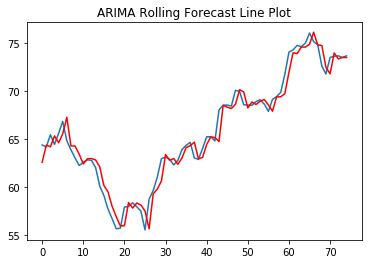

In [57]:

for t in range(len(test)):
    model = ARIMA(history, order=(4,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    l = output[2].tolist()
    conf.append(l)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA Rolling Forecast Line Plot")
plt.show()

In [ ]:
print(type(conf))
lower = pd.Series( (v[0][0] for v in conf), index=y_test.index )

upper = pd.Series( (v[0][1] for v in conf), index=y_test.index )


In [58]:
fc_series = pd.Series(predictions, index=y_test.index)
lower_series = pd.Series( (v[0][0] for v in conf), index=y_test.index )
upper_series = pd.Series( (v[0][1] for v in conf), index=y_test.index )

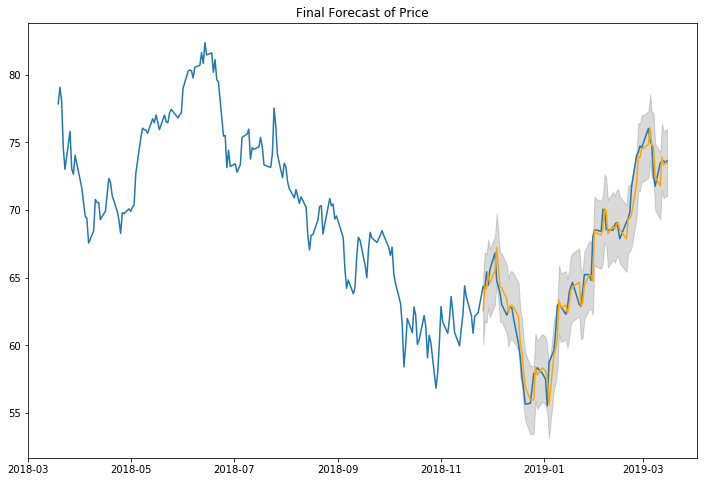

In [59]:
# Plot
fig = plt.figure(figsize=(12, 8))
plt.plot(normed[symbol])
plt.plot(fc_series, color='orange')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Price")
plt.show()

## Evaluate The Model

### Showing summary

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  249
Model:                     ARMA(4, 1)   Log Likelihood                -410.166
Method:                       css-mle   S.D. of innovations              1.248
Date:                Wed, 20 Mar 2019   AIC                            834.332
Time:                        19:51:00   BIC                            858.954
Sample:                             0   HQIC                           844.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.0226      3.612     19.666      0.000      63.944      78.101
ar.L1.y        0.4486      0.224      2.004      0.046       0.010       0.887
ar.L2.y        0.5038      0.242      2.079      0.0

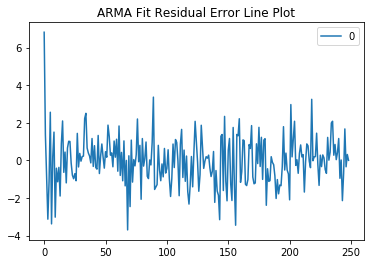

/home/emi/miniconda3/envs/factors/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:


Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.



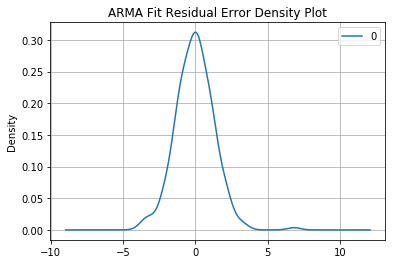

                0
count  249.000000
mean    -0.028061
std      1.320778
min     -3.699594
25%     -0.909024
50%     -0.002872
75%      0.845789
max      6.817390


In [60]:
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.title("ARMA Fit Residual Error Line Plot")
plt.show()
residuals.plot(kind='kde')
plt.title("ARMA Fit Residual Error Density Plot")
plt.grid("on")
plt.show()
print(residuals.describe())

### Correlation

A way to visualize and evaluate the accuracy of a regression algorithm is to look at the relationship between predicted and actual values of our dependant variable Y.

A value along the horizontal access is the prediction and along the vertical axis is what the ground truth is.

You'll get an answer somewhere between -1 and +1. Where +1 means they're strongly correlated, -1 means they're inversely correlated, and 0 means there's essentially no correlation at all between them.


In [61]:
# Create a dataframe for plotting
pred_df = pd.DataFrame()
pred_df['Price'] = test
se = pd.Series(predictions)
pred_df['Forecast'] = se
pred_df['Forecast'] = pred_df['Forecast'].astype(float)

In [62]:
print('Correlation: \n', np.corrcoef(pred_df['Forecast'], pred_df['Price']))

Correlation: 
 [[1.         0.97878512]
 [0.97878512 1.        ]]


### Plot correlation matrix

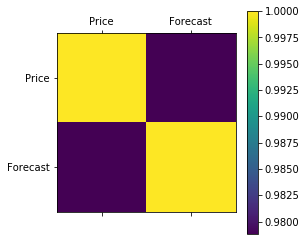

In [63]:
plt.matshow(pred_df.corr())
plt.xticks(range(len(pred_df.columns)), pred_df.columns)
plt.yticks(range(len(pred_df.columns)), pred_df.columns)
plt.colorbar()
plt.show()

### Plot slope line and elipse

So if it's a nice oval that fits close to the slope line, we usually have a high correlation. If it's a big round thing we've got poor correlation.


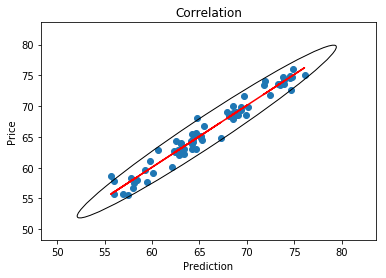

In [64]:
# Slope line
a = pred_df['Forecast']
b = pred_df['Price']
# Find the slope and intercept of the best fit line
slope, intercept = np.polyfit(a, b, 1)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in a]

# Create an ellipse
cov = np.cov(a, b)
lambda_, v = np.linalg.eig(cov)
lambda_ = np.sqrt(lambda_)

ax = plt.subplot(111, aspect='auto')

ell = Ellipse(xy=(np.mean(a), np.mean(b)),
              width=lambda_[0]*5, height=lambda_[1]*5,
              angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='black')
ell.set_facecolor('none')

# Max and min values for lim
maxlim = max(b) * 1.1
minlim = min(b) / 1.15
ax.add_artist(ell)
ax.set(xlim=[minlim, maxlim], ylim=[minlim, maxlim])

plt.scatter(a, b)
plt.plot(a, abline_values, 'r')
plt.title("Correlation")
plt.xlabel('Prediction')
plt.ylabel("Price")
plt.show()



## Saving an ARIMA Time Series Forecasting Model

The statsmodels library provides an implementation of ARIMA for use in Python. ARIMA models can be saved to file for later use in making predictions on new data. There is a bug in the earlier versions to 0.9 of the statsmodels library that prevents saved models from being loaded.


In [65]:
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [66]:
# save model
model_fit.save('arima_model.pkl')


# Loading a model and predicting future prices

Load the model and use it to forecast the next steps. 

In [55]:
symbol = "AMZN"

# We'll look back 365 days
start_d = dt.date.today() - dt.timedelta(365)

## Getting data from Yahoo

In [56]:
yesterday = dt.date.today() - dt.timedelta(1)
portf_value = fetchOnlineData(start_d, symbol, yesterday)

[*********************100%***********************]  1 of 1 downloaded


In [57]:
# load model
model = ARIMAResults.load('arima_model.pkl')

print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  249
Model:                     ARMA(4, 1)   Log Likelihood                -410.166
Method:                       css-mle   S.D. of innovations              1.248
Date:                Tue, 26 Mar 2019   AIC                            834.332
Time:                        21:14:25   BIC                            858.954
Sample:                             0   HQIC                           844.243
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.0226      3.612     19.666      0.000      63.944      78.101
ar.L1.y        0.4486      0.224      2.004      0.046       0.010       0.887
ar.L2.y        0.5038      0.242      2.079      0.0

In [58]:
forecast_lookback = 365
forecast_date = dt.date.today()
# Setting dates and prices dataframe                                            
lookback_date = dt.date.today() - dt.timedelta(forecast_lookback)               
dates = pd.date_range(lookback_date, periods=forecast_lookback)                 
df_prices = slice_df(portf_value, dates)                                        
                                                                                
# Bussines days                                                                 
start = forecast_date.strftime("%Y-%m-%d")                                      
rng = pd.date_range(pd.Timestamp(start),  periods=forecast_time, freq='B')      
                                                                                

In [70]:
# Bussines days
start = forecast_date.strftime("%Y-%m-%d")
rng = pd.date_range(pd.Timestamp(start),  periods=forecast_time, freq='B')
bussines_days = rng.strftime('%Y-%m-%d')

## Rolling forecast


### Getting data from Yahoo

In [60]:
#missing data
total = portf_value.isnull().sum().sort_values(ascending=False)
percent = (portf_value.isnull().sum()/portf_value.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)

           Total  Percent
Adj Close      0      0.0


In [61]:
# Preparing data                               
predictions = list()                           
conf = list()                                                                          

In [62]:
# Create date column to save next date
portf_value['date'] = portf_value.index


# load the dataset
dataset = np.array(portf_value.iloc[:, 0].tolist())[np.newaxis]
dataset = dataset.T
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [63]:
# Prediction
model = ARIMA(history, order=(4,0,1))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()

In [64]:
forecast_time = 7
for i in range(0, forecast_time):
    # load the dataset
    dataset = np.array(portf_value.iloc[:, 0].tolist())[np.newaxis]
    dataset = dataset.T
    dataset = dataset.astype('float32')

    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # predict
    model = ARIMA(dataset, order=(4,0,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()

    # Prediction Inverse scale
    prediction = yhat[0].reshape(-1, 1)
    futurePredict = scaler.inverse_transform(prediction)

    # observation
    inv_scaled_conf =  scaler.inverse_transform(yhat[2].reshape(1, -1))
    l = inv_scaled_conf.tolist()

    conf.append(l)

    # Adding last prediction to portf_value
    prediction = futurePredict.item(0)
    portf_value.loc[len(portf_value)] = [prediction, i]

    # Adding value to predictions dataframe
    predictions.append([prediction, i])
    print('No.=%f, predicted=%f' % (i, prediction))

No.=0.000000, predicted=1757.387702
No.=1.000000, predicted=1761.761566
No.=2.000000, predicted=1753.441512
No.=3.000000, predicted=1757.187211
No.=4.000000, predicted=1749.426759
No.=5.000000, predicted=1752.913116
No.=6.000000, predicted=1745.656712


In [65]:
conf

[[[1684.451600051443, 1830.3238032666775]],
 [[1688.9710025899128, 1834.5521286490803]],
 [[1680.7956309477818, 1826.0873928804192]],
 [[1684.6851871253064, 1829.689235796865]],
 [[1677.067687261037, 1821.7858313723543]],
 [[1680.6962061263996, 1825.1300251883752]],
 [[1673.5810866794006, 1817.7323373236588]]]

## Plotting predictions

From https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [73]:
rng


DatetimeIndex(['2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
               '2019-04-01', '2019-04-02', '2019-04-03'],
              dtype='datetime64[ns]', freq='B')

In [72]:
# Make as pandas series
fc_series = pd.Series(predictions, index=rng)
lower_series = pd.Series(conf[:, 0], index=rng)
upper_series = pd.Series(conf[:, 1], index=rng)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_prices['Adj Close'], label='training')
#plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

TypeError: list indices must be integers or slices, not tuple

In [54]:
# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)
#init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

trace0 = go.Scatter(
    x=lower_series.index,
    y=lower_series.values,
    fill= None,
    mode='lines',
    line=dict(
        color='rgb(143, 19, 131)',
    )
)
trace1 = go.Scatter(
    x=upper_series.index,
    y=upper_series.values,
    fill='tonexty',
    mode='lines',
    line=dict(
        color='rgb(143, 19, 131)',
    )
)

data = [trace0, trace1]
#py.iplot(data, filename='filling-interior-area')

layout = dict(
        title = "ARIMA FORECAST MODEL",
        showlegend=True,
        legend=dict(
                orientation="h"),
        margin=go.layout.Margin(
            l=50,
            r=10,
            b=100,
            t=100,
            pad=4
        ),
        
    )
fig = dict(data=data, layout=layout)
plot(fig, show_link=False)

'file:///home/emi/miniconda3/envs/factors/temp-plot.html'